In [149]:
import os
import pandas as pd
import numpy as np 
import plotly
import re
from datetime import datetime
import explainerdashboard
from d3blocks import d3blocks
from nltk.corpus import stopwords
import string
import nltk
import docx
from collections.abc import Iterable
from pattern.en import sentiment, subjectivity
import seaborn as sns
import plotly.express as px

In [150]:
nltk.download('stopwords')
sw = set(stopwords.words('english'))
list(sw)[0:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Heather\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['them',
 "didn't",
 'should',
 'both',
 'own',
 'such',
 'over',
 "wouldn't",
 'any',
 'hers']

In [151]:
print(set(string.punctuation))

{')', '\\', '$', '@', '.', '!', '`', '/', '?', ']', '*', ';', '+', '>', '%', '#', ':', '_', '{', '<', '[', '-', '~', '"', '=', '^', '|', '&', ',', '}', '(', "'"}


### Employee Records

In [152]:
employee_records_df = pd.read_excel('EmployeeRecords.xlsx', sheet_name='Employee Records')
employee_records_df.head(2)

,LastName,FirstName,BirthDate,BirthCountry,Gender,CitizenshipCountry,CitizenshipBasis,CitizenshipStartDate,PassportCountry,PassportIssueDate,PassportExpirationDate,CurrentEmploymentType,CurrentEmploymentTitle,CurrentEmploymentStartDate,EmailAddress,MilitaryServiceBranch,MilitaryDischargeType,MilitaryDischargeDate
0,Bramar,Mat,1981-12-19,Tethys,Male,Tethys,BirthNation,1981-12-19,Tethys,2007-12-12,2017-12-11,Administration,Assistant to CEO,2005-07-01,Mat.Bramar@gastech.com.kronos,NaN,NaN,NaT
1,Ribera,Anda,1975-11-17,Tethys,Female,Tethys,BirthNation,1975-11-17,Tethys,2009-06-15,2019-06-14,Administration,Assistant to CFO,2009-10-30,Anda.Ribera@gastech.com.kronos,NaN,NaN,NaT


For datetime64[ns] types, NaT represents missing values. (Not a valid time). 

While NaN is the default missing value marker for reasons of computational speed and convenience. In many cases, however, the Python `None` will arise and we wish to also consider that “missing” or “not available” or “NA”. 

In [153]:
index_employee_records_df = pd.read_excel('EmployeeRecords.xlsx', sheet_name='Index')
index_employee_records_df.head(3)

,Field Name,Description
0,LastName,the last name of the employee
1,FirstName,the first name of the employee
2,BirthDate,the birth date of the employee


In [154]:
employee_records_df.shape

(54, 18)

In [155]:
employee_records_df.dtypes

LastName                              object
FirstName                             object
BirthDate                     datetime64[ns]
BirthCountry                          object
Gender                                object
CitizenshipCountry                    object
CitizenshipBasis                      object
CitizenshipStartDate          datetime64[ns]
PassportCountry                       object
PassportIssueDate             datetime64[ns]
PassportExpirationDate        datetime64[ns]
CurrentEmploymentType                 object
CurrentEmploymentTitle                object
CurrentEmploymentStartDate    datetime64[ns]
EmailAddress                          object
MilitaryServiceBranch                 object
MilitaryDischargeType                 object
MilitaryDischargeDate         datetime64[ns]
dtype: object

In [156]:
employee_records_df.isnull().sum()

LastName                       0
FirstName                      0
BirthDate                      0
BirthCountry                   0
Gender                         0
CitizenshipCountry             0
CitizenshipBasis               0
CitizenshipStartDate           0
PassportCountry               21
PassportIssueDate             21
PassportExpirationDate        21
CurrentEmploymentType          0
CurrentEmploymentTitle         0
CurrentEmploymentStartDate     0
EmailAddress                   0
MilitaryServiceBranch         27
MilitaryDischargeType         27
MilitaryDischargeDate         27
dtype: int64

The missingness means the employee did not serve in a military branch.

The missingness from passport means they did not own a passport.

#### Feature Engineering: Create Full Name column

In [157]:
employee_records_df['FullName'] = employee_records_df['FirstName'] + ' ' + employee_records_df['LastName']

### Employee Emails

In [158]:
# single-byte charcter encoding of the latin alphabet
email_df = pd.read_csv('emailheaders.csv', encoding='cp1252')
email_df.head()

,From,To,Date,Subject
0,Sven.Flecha@gastech.com.kronos,"Isak.Baza@gastech.com.kronos, Lucas.Alcazar@ga...",1/6/2014 8:39,GT-SeismicProcessorPro Bug Report
1,Kanon.Herrero@gastech.com.kronos,"Felix.Resumir@gastech.com.kronos, Hideki.Cocin...",1/6/2014 8:58,Inspection request for site
2,Bertrand.Ovan@gastech.com.kronos,"Emile.Arpa@gastech.com.kronos, Varro.Awelon@ga...",1/6/2014 9:28,New refueling policies - Effective February 1
3,Valeria.Morlun@gastech.com.kronos,"Dante.Coginian@gastech.com.kronos, Albina.Hafo...",1/6/2014 9:38,Route suggestion for next shift
4,Mat.Bramar@gastech.com.kronos,"Rachel.Pantanal@gastech.com.kronos, Lars.Azada...",1/6/2014 9:49,Upcoming birthdays


In [159]:
print(email_df.shape)
print(email_df.dtypes)

(1170, 4)
From       object
To         object
Date       object
Subject    object
dtype: object


In [160]:
def stripEmail(email):
    return re.sub(pattern=r"\br\.|@[a-z][a-z.+]+.", repl="", string=email)

def addSplit(email):
    return re.sub(pattern="\.", repl=" ", string=email)

email_df['From'] = email_df['From'].apply(lambda x: stripEmail(x))
email_df['From'] = email_df['From'].apply(lambda x: addSplit(x))
email_df.head(3)

,From,To,Date,Subject
0,Sven Flecha,"Isak.Baza@gastech.com.kronos, Lucas.Alcazar@ga...",1/6/2014 8:39,GT-SeismicProcessorPro Bug Report
1,Kanon Herrero,"Felix.Resumir@gastech.com.kronos, Hideki.Cocin...",1/6/2014 8:58,Inspection request for site
2,Bertrand Ovan,"Emile.Arpa@gastech.com.kronos, Varro.Awelon@ga...",1/6/2014 9:28,New refueling policies - Effective February 1


#todo add assert from employee verification check

In [161]:
def stripEmail_From(email):
    return re.sub(pattern=r"\br\.|@[a-z][a-z.+]+.", repl="", string=email)

def addSplit(email):
    return re.sub(pattern="\.", repl=" ", string=email)

In [162]:
# M/D/YYYY
email_df['Date'] = pd.to_datetime(email_df['Date'], errors='raise')
email_df.dtypes

From               object
To                 object
Date       datetime64[ns]
Subject            object
dtype: object

In [163]:
print(email_df.shape)

(1170, 4)


In [164]:
punctuation = None 

def clean(text, stopwords) -> str:
    """
    Clean text sentence 
    Params: text: the string to clean
    stopwords: a list of NLTK stopwords to remove from input row
    Returns: cleaned sentence
    """ 
    text = re.sub(r'<[^>?]*>', '', text)
    text_list = text.split()
    text_words = []
    punctuation = set(string.punctuation)
    
    for word in text_list: 
        while len(word) > 0 and word[0] in punctuation: 
            word = word[1:]
        
        while len(word) > 0 and word[-1] in punctuation: 
            word = word[:-1]
            
        word = word.replace(',', '')
        word = word.replace('\"', '')
        word = word.replace('\'', '')

        if len(word) > 0 and "/" not in word: 
            if word.lower() not in stopwords: 
                text_words.append(word.lower())
        cleaner_text = " ".join(text_words)
    return cleaner_text

email_df['Subject'] = email_df['Subject'].apply(clean, stopwords=sw)
email_df.head(3)

,From,To,Date,Subject
0,Sven Flecha,"Isak.Baza@gastech.com.kronos, Lucas.Alcazar@ga...",2014-01-06 08:39:00,gt-seismicprocessorpro bug report
1,Kanon Herrero,"Felix.Resumir@gastech.com.kronos, Hideki.Cocin...",2014-01-06 08:58:00,inspection request site
2,Bertrand Ovan,"Emile.Arpa@gastech.com.kronos, Varro.Awelon@ga...",2014-01-06 09:28:00,new refueling policies effective february 1


### News Articles

News articles contain historical information.

In [165]:
def extract_article_name(name) -> str:
    """
    Params: str: article name
    Returns:
        str: shorten file name
    """
    return "article " + re.sub(pattern=r"\.+.*", repl="", string=name)

def extract_datetime(file) -> list:
    """
    Extract datetime of news article for timeline
    Params: article to parse
    Returns: list of matches or empty list if no matches
    """
    return re.findall(r'\d+/\d+/\d+', file) or re.findall(r'\d+ \w+ \d+', file) or re.findall(r'\d+\w+ \d+', file) or re.findall(r'\d+ \w+  \d+', file)

def extract_news_company(file) -> str:
    """
    Extract News outlet
    Params: article to parse
    Returns: list of matches or empty list if no matches
    """
    return re.match(r'\A.*', file).group()

def extract_data(rootdir, news_article) -> dict:
    """
    Params:
        rootdir (Path): path to search for article files
        news_article (dict): empty dict to fill of <article, description>
    Returns:
        news_article: full <article, description> dict
    """
    assert os.path.exists(rootdir)
    for subdir, dirs, files in os.walk(rootdir):
        assert os.path.exists(subdir)
        for file in files:
            if file.__contains__('txt'):
                nav_file = os.path.join(subdir, file)
                with open(nav_file, 'r') as datafile:
                    try:
                        news_name = extract_article_name(file)
                        news_article[news_name] = datafile.read()
                        datafile.close()
                    except Exception as ex:
                        print("Failed to parse article: ", ex)
                        continue
    return news_article

news_article = {}
rootdir = 'articles/'
news_article = extract_data(rootdir, news_article)
articles_df = pd.DataFrame.from_dict(data=news_article, orient='index', columns=['description'])
articles_df['news_company'] = articles_df['description'].apply(lambda x: extract_news_company(x))
articles_df['datetime'] = articles_df['description'].apply(lambda x: extract_datetime(x))
articles_df.reset_index(inplace=True)
print(articles_df.shape)
print(articles_df.dtypes)
articles_df.head()

(845, 4)
index           object
description     object
news_company    object
datetime        object
dtype: object


,index,description,news_company,datetime
0,article 0,The Orb\n\n\nBUMP OF PROTESTS IN ABILA IN RESP...,The Orb,[2012/09/08]
1,article 1,The Light of Truth\n\nENORMOUS IPO MAKES THE B...,The Light of Truth,[2013/12/18]
2,article 10,Homeland Illumination\nVOICES - a blog about w...,Homeland Illumination,"[20 January 2014, 20 Jan 2014]"
3,article 100,The Continent\n\nFour people have died in an e...,The Continent,[2007/03/19]
4,article 101,Daily Pegasus\n\nTHE DEMONSTRATION ATTRACTS TH...,Daily Pegasus,[2012/11/11]


In [166]:
articles_df['description'] = articles_df['description'].apply(clean, stopwords=sw)
articles_df.head()

,index,description,news_company,datetime
0,article 0,orb bump protests abila response calls action ...,The Orb,[2012/09/08]
1,article 1,light truth enormous ipo makes billionaire san...,The Light of Truth,[2013/12/18]
2,article 10,homeland illumination voices blog important pe...,Homeland Illumination,"[20 January 2014, 20 Jan 2014]"
3,article 100,continent four people died enthusiastic discha...,The Continent,[2007/03/19]
4,article 101,daily pegasus demonstration attracts thousands...,Daily Pegasus,[2012/11/11]


### Resumes

Using resumes to look up historical employee data

In [167]:
def extract_resume_name(name) -> str:
    """
    Params: str: resume name
    Returns:
        str: shorten file name
    """
    name = re.sub(pattern=r"\.+.*|Bio|Resume", repl="", string=name)
    name = re.sub(pattern=r"-", repl=" ", string=name)
    return name

def extract_data(rootdir, resumes) -> dict:
    """
    Params:
        rootdir (Path): path to search for article files
        news_article (dict): empty dict to fill of <article, description>
    Returns:
        news_article: full <article, description> dict
    """
    assert os.path.exists(rootdir)
    for subdir, dirs, files in os.walk(rootdir):
        assert os.path.exists(subdir)
        for file in files:
            if file.__contains__('docx'):
                nav_file = os.path.join(subdir, file)
                with open(nav_file, 'r') as datafile:
                    try:
                        resume_name = extract_resume_name(file)
                        doc = docx.Document(nav_file)
                        fullText = []
                        for para in doc.paragraphs:
                            fullText.append(para.text)
                        resumes[resume_name] = '\n'.join(fullText)
                        datafile.close()
                    except Exception as ex:
                        print("Failed to parse resume: ", ex)
                        continue
    return resumes

resumes = {}
rootdir = 'resumes/'
resumes = extract_data(rootdir, resumes)
resumes_df = pd.DataFrame.from_dict(data=resumes, orient='index', columns=['resume'])
resumes_df.reset_index(inplace=True)
print(resumes_df.shape)
resumes_df.head()

(35, 2)


,index,resume
0,Ada Campo,Ada Campo-Corrente\nChief Information Officer\...
1,Ingrid Barranco,Ingrid Barranco\nChief Financial Officer\n\n\n...
2,OrhanStrum,Orhan Strum\nChief Operating Officer\n\n\nMr. ...
3,Sten SanjorgeJr,"Sten Sanjorge, Jr\nPresident & CEO GASTech\nTe..."
4,Willem Vasco,Willem Vasco-Pais\nEnvironmental Safety Adviso...


In [168]:
def clean_text_resume(text):
    text = re.sub(r'<[^>?]*>', '', text)
    text_list = text.split()
    text_words = []
    punctuation = set(string.punctuation)
    
    for word in text_list: 
        while len(word) > 0 and word[0] in punctuation: 
            word = word[1:]
        
        while len(word) > 0 and word[-1] in punctuation: 
            word = word[:-1]
            
        word = word.replace(',', '')
        word = word.replace('\"', '')
        word = word.replace('\'', '')

        if len(word) > 0 and "/" not in word: 
            text_words.append(word.lower())
        cleaner_text = " ".join(text_words)
    return cleaner_text

resumes_df['resume'] = resumes_df['resume'].apply(clean_text_resume)
resumes_df.head()

,index,resume
0,Ada Campo,ada campo-corrente chief information officer m...
1,Ingrid Barranco,ingrid barranco chief financial officer ms ing...
2,OrhanStrum,orhan strum chief operating officer mr strum s...
3,Sten SanjorgeJr,sten sanjorge jr president ceo gastech tethys ...
4,Willem Vasco,willem vasco-pais environmental safety advisor...


### Historical Documents

In [169]:
def extract_doc_name(name) -> str:
    """
    Params: str: resume name
    Returns:
        str: shorten file name
    """
    return re.match(pattern=r"^([0-9]+ year).*$", string=name).group(1)

def extract_data(rootdir, hist_doc) -> dict:
    """
    Params:
        rootdir (Path): path to search for files
        news_article (dict): empty dict to fill of <article, description>
    Returns:
        news_article: full <article, description> dict
    """
    assert os.path.exists(rootdir)
    for subdir, dirs, files in os.walk(rootdir):
        assert os.path.exists(subdir)
        for file in files:
            if file.__contains__('docx'):
                nav_file = os.path.join(subdir, file)
                with open(nav_file, 'r') as datafile:
                    try:
                        hist_name = extract_doc_name(file)
                        doc = docx.Document(nav_file)
                        fullText = []
                        for para in doc.paragraphs:
                            fullText.append(para.text)
                        hist_doc[hist_name] = '\n'.join(fullText)
                        datafile.close()
                    except Exception as ex:
                        print("Failed to parse resume: ", ex)
                        continue
    return hist_doc

historical_doc = {}
rootdir = 'HistoricalDocuments/'
historical_doc = extract_data(rootdir, historical_doc)
historical_df = pd.DataFrame.from_dict(data=historical_doc, orient='index', columns=['description'])
historical_df.reset_index(inplace=True)
print(historical_df.shape)
historical_df.head()

(2, 2)


,index,description
0,10 year,\n\n<EXCERPTS from>The Application and Validat...
1,5 year,History of the Protectors of Kronos\nA Psycorp...


In [170]:
historical_df['description'].apply(clean_text_resume)
historical_df.head()

,index,description
0,10 year,\n\n<EXCERPTS from>The Application and Validat...
1,5 year,History of the Protectors of Kronos\nA Psycorp...


### FactBook

In [171]:
def extract_doc_name(name) -> str:
    """
    Params: str: resume name
    Returns:
        str: shorten file name
    """
    return re.match(pattern=r"^.*?(?=\.)", string=name).group(0)

def extract_data(rootdir, hist_doc) -> dict:
    """
    Params:
        rootdir (Path): path to search for files
        news_article (dict): empty dict to fill of <file name, description>
    Returns:
        news_article: full <file name, description> dict
    """
    assert os.path.exists(rootdir)
    for subdir, dirs, files in os.walk(rootdir):
        assert os.path.exists(subdir)
        for file in files:
            if file.__contains__('docx'):
                nav_file = os.path.join(subdir, file)
                with open(nav_file, 'r') as datafile:
                    try:
                        print(file)
                        file_name = str.lower(extract_doc_name(file))
                        doc = docx.Document(nav_file)
                        fullText = []
                        for para in doc.paragraphs:
                            fullText.append(para.text)
                        factbook_doc[file_name] = '\n'.join(fullText)
                        datafile.close()
                    except Exception as ex:
                        print("Failed to parse factbook: ", ex)
                        continue
    return factbook_doc

factbook_doc = {}
rootdir = 'factbook/'
factbook_doc = extract_data(rootdir, factbook_doc)
factbook_df = pd.DataFrame.from_dict(data=factbook_doc, orient='index', columns=['description'])
factbook_df.reset_index(inplace=True)
print(factbook_df.shape)
factbook_df.head()

FACTBOOK-Kronos.docx
FACTBOOK-Tethys.docx
(2, 2)


,index,description
0,factbook-kronos,FACTBOOK :: Kronos \nIntroduction\nBackground:...
1,factbook-tethys,FACTBOOK :: Tethys\n\nIntroduction\nBackground...


In [172]:
factbook_df['description'].apply(clean_text_resume)
factbook_df.head()

,index,description
0,factbook-kronos,FACTBOOK :: Kronos \nIntroduction\nBackground:...
1,factbook-tethys,FACTBOOK :: Tethys\n\nIntroduction\nBackground...


### Email Analysis

In [173]:
email_df.head()

,From,To,Date,Subject
0,Sven Flecha,"Isak.Baza@gastech.com.kronos, Lucas.Alcazar@ga...",2014-01-06 08:39:00,gt-seismicprocessorpro bug report
1,Kanon Herrero,"Felix.Resumir@gastech.com.kronos, Hideki.Cocin...",2014-01-06 08:58:00,inspection request site
2,Bertrand Ovan,"Emile.Arpa@gastech.com.kronos, Varro.Awelon@ga...",2014-01-06 09:28:00,new refueling policies effective february 1
3,Valeria Morlun,"Dante.Coginian@gastech.com.kronos, Albina.Hafo...",2014-01-06 09:38:00,route suggestion next shift
4,Mat Bramar,"Rachel.Pantanal@gastech.com.kronos, Lars.Azada...",2014-01-06 09:49:00,upcoming birthdays


In [174]:
groupby_name = email_df.copy()
groupby_name = email_df.groupby(by=['From'])
groupby_name = groupby_name.count().sort_values(by='To', ascending=False)
groupby_name.head()

,To,Date,Subject
From,,,
Lucas Alcazar,59,59,59
Nils Calixto,54,54,54
Isak Baza,50,50,50
Sven Flecha,42,42,42
Mat Bramar,42,42,42



Create a commuication network within the GASTech organization and Protectors of Kronos members.

In [175]:
total_email_count = email_df.shape[0]
groupby_name['Frequency'] = groupby_name['To'].apply(lambda x: (x/total_email_count)*100)
groupby_name.head()

,To,Date,Subject,Frequency
From,,,,
Lucas Alcazar,59,59,59,5.042735
Nils Calixto,54,54,54,4.615385
Isak Baza,50,50,50,4.273504
Sven Flecha,42,42,42,3.589744
Mat Bramar,42,42,42,3.589744


In [176]:
comm_network = email_df.groupby(by=['From'])
comm_network.head()

,From,To,Date,Subject
0,Sven Flecha,"Isak.Baza@gastech.com.kronos, Lucas.Alcazar@ga...",2014-01-06 08:39:00,gt-seismicprocessorpro bug report
1,Kanon Herrero,"Felix.Resumir@gastech.com.kronos, Hideki.Cocin...",2014-01-06 08:58:00,inspection request site
2,Bertrand Ovan,"Emile.Arpa@gastech.com.kronos, Varro.Awelon@ga...",2014-01-06 09:28:00,new refueling policies effective february 1
3,Valeria Morlun,"Dante.Coginian@gastech.com.kronos, Albina.Hafo...",2014-01-06 09:38:00,route suggestion next shift
4,Mat Bramar,"Rachel.Pantanal@gastech.com.kronos, Lars.Azada...",2014-01-06 09:49:00,upcoming birthdays
...,...,...,...,...
750,Minke Mies,Inga.Ferro@gastech.com.kronos,2014-01-14 15:36:00,late meeting
821,Marin Onda,Emile.Arpa@gastech.com.kronos,2014-01-15 11:17:00,files
829,Linnea Bergen,Claudio.Hawelon@gastech.com.kronos,2014-01-15 12:10:00,favor borrow hedge trimmer
848,Birgitta Frente,"Marin.Onda@gastech.com.kronos, Brand.Tempestad...",2014-01-15 13:26:00,wellhead flow rate data overpressure well 1783-03


How frequently do people contact each other? ie. Ada emailed Felix 2 times.

In [177]:
emails_sent = pd.DataFrame()
for employee_from_name, employee_to_name in comm_network:
    name_map_frequency = {}
    for arr_name in employee_to_name['To']:
        # check that email exists in employee records df
        counter = 0
        if arr_name.__contains__(","):
            arr_name = arr_name.split(",")
            for employee in arr_name: 
                try:
                    assert employee_records_df['EmailAddress'].eq(employee.strip()).any()
                    counter+=1
                    employee = stripEmail(employee)
                    employee = addSplit(employee)
                    name_map_frequency[employee] = name_map_frequency.get(employee, 0) + counter
                except Exception as ex:
                    print(employee)
        else:
            try:
                assert employee_records_df['EmailAddress'].eq(arr_name).any()
                counter+=1
                arr_name = stripEmail(arr_name)
                arr_name = addSplit(arr_name)
                name_map_frequency[arr_name] = name_map_frequency.get(arr_name, 0) + counter
            except Exception as ex:
                print(arr_name)
    emails_sent[employee_from_name] = name_map_frequency    
emails_sent = emails_sent.T

C:\Users\Heather\AppData\Local\Temp\ipykernel_10744\3833676466.py:2: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



 Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
Sten.Sanjorge Jr.@gastech.com.tethys
Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
Sten.Sanjorge Jr.@gastech.com.tethys
Sten.Sanjorge Jr.@gastech.com.tethys
Sten.Sanjorge Jr.@gastech.com.tethys
Sten.Sanjorge Jr.@gastech.com.tethys
Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@gastech.com.tethys
 Sten.Sanjorge Jr.@ga

In [178]:
# email_df['To'] = email_df['To'].apply(lambda x: stripEmail_From(x))
# email_df['To'] = email_df['To'].apply(lambda x: addSplit(x))

In [179]:
emails_sent.head()

,Felix Resumir,Rachel Pantanal,Lars Azada,Felix Balas,Isande Borrasca,Axel Calzas,Gustav Cazar,Lidelse Dedos,Birgitta Frente,Vira Frente,...,Carla Forluniau,Linda Lagos,Cornelia Lais,Ruscella Mies Haber,Anda Ribera,Orhan Strum,Ada Campo-Corrente,Ingrid Barranco,Ruscella Mies Haber,Willem Vasco-Pais
Ada Campo-Corrente,2.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,...,100.0,102.0,104.0,106.0,108.0,3.0,4.0,4.0,1.0,3.0
Adan Morlun,NaN,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,50.0,51.0,52.0,53.0,54.0,NaN,NaN,NaN,NaN,NaN
Adra Nubarron,NaN,3.0,19.0,24.0,18.0,18.0,34.0,36.0,39.0,39.0,...,150.0,153.0,156.0,159.0,162.0,NaN,NaN,NaN,2.0,NaN
Albina Hafon,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anda Ribera,NaN,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,128.0,103.0,143.0,118.0,80.0,NaN,NaN,NaN,NaN,NaN


In [180]:
emails_sent.columns = emails_sent.columns.str.strip()

In [181]:
emails_sent.shape

(54, 60)

In [182]:
emails_sent.fillna(0, inplace=True)
emails_sent.head()

,Felix Resumir,Rachel Pantanal,Lars Azada,Felix Balas,Isande Borrasca,Axel Calzas,Gustav Cazar,Lidelse Dedos,Birgitta Frente,Vira Frente,...,Carla Forluniau,Linda Lagos,Cornelia Lais,Ruscella Mies Haber,Anda Ribera,Orhan Strum,Ada Campo-Corrente,Ingrid Barranco,Ruscella Mies Haber,Willem Vasco-Pais
Ada Campo-Corrente,2.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,...,100.0,102.0,104.0,106.0,108.0,3.0,4.0,4.0,1.0,3.0
Adan Morlun,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,50.0,51.0,52.0,53.0,54.0,0.0,0.0,0.0,0.0,0.0
Adra Nubarron,0.0,3.0,19.0,24.0,18.0,18.0,34.0,36.0,39.0,39.0,...,150.0,153.0,156.0,159.0,162.0,0.0,0.0,0.0,2.0,0.0
Albina Hafon,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anda Ribera,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,128.0,103.0,143.0,118.0,80.0,0.0,0.0,0.0,0.0,0.0


In [183]:
print(emails_sent.columns)

Index(['Felix Resumir', 'Rachel Pantanal', 'Lars Azada', 'Felix Balas',
       'Isande Borrasca', 'Axel Calzas', 'Gustav Cazar', 'Lidelse Dedos',
       'Birgitta Frente', 'Vira Frente', 'Adra Nubarron', 'Marin Onda',
       'Kare Orilla', 'Elsa Orilla', 'Brand Tempestad', 'Ingrid Barranco',
       'Ada Campo-Corrente', 'Sten Sanjorge Jr', 'Orhan Strum',
       'Willem Vasco-Pais', 'Bertrand Ovan', 'Albina Hafon', 'Benito Hawelon',
       'Claudio Hawelon', 'Henk Mies', 'Valeria Morlun', 'Adan Morlun',
       'Cecilia Morluniau', 'Irene Nant', 'Dylan Scozzese', 'Lucas Alcazar',
       'Isak Baza', 'Linnea Bergen', 'Nils Calixto', 'Sven Flecha',
       'Hideki Cocinaro', 'Inga Ferro', 'Loreto Bodrogi', 'Isia Vann',
       'Stenig Fusil', 'Hennie Osvaldo', 'Kanon Herrero', 'Varja Lagos',
       'Minke Mies', 'Felix Resumir', 'Edvard Vann', 'Emile Arpa',
       'Varro Awelon', 'Mat Bramar', 'Dante Coginian', 'Carla Forluniau',
       'Linda Lagos', 'Cornelia Lais', 'Ruscella Mies Haber', 

In [184]:
emails_sent = emails_sent.loc[:,~emails_sent.columns.duplicated()].copy()
emails_sent.columns

Index(['Felix Resumir', 'Rachel Pantanal', 'Lars Azada', 'Felix Balas',
       'Isande Borrasca', 'Axel Calzas', 'Gustav Cazar', 'Lidelse Dedos',
       'Birgitta Frente', 'Vira Frente', 'Adra Nubarron', 'Marin Onda',
       'Kare Orilla', 'Elsa Orilla', 'Brand Tempestad', 'Ingrid Barranco',
       'Ada Campo-Corrente', 'Sten Sanjorge Jr', 'Orhan Strum',
       'Willem Vasco-Pais', 'Bertrand Ovan', 'Albina Hafon', 'Benito Hawelon',
       'Claudio Hawelon', 'Henk Mies', 'Valeria Morlun', 'Adan Morlun',
       'Cecilia Morluniau', 'Irene Nant', 'Dylan Scozzese', 'Lucas Alcazar',
       'Isak Baza', 'Linnea Bergen', 'Nils Calixto', 'Sven Flecha',
       'Hideki Cocinaro', 'Inga Ferro', 'Loreto Bodrogi', 'Isia Vann',
       'Stenig Fusil', 'Hennie Osvaldo', 'Kanon Herrero', 'Varja Lagos',
       'Minke Mies', 'Edvard Vann', 'Emile Arpa', 'Varro Awelon', 'Mat Bramar',
       'Dante Coginian', 'Carla Forluniau', 'Linda Lagos', 'Cornelia Lais',
       'Ruscella Mies Haber', 'Anda Ribera'],
 

In [185]:
emails_sent.shape

(54, 54)

In [186]:
emails_sent.head()

,Felix Resumir,Rachel Pantanal,Lars Azada,Felix Balas,Isande Borrasca,Axel Calzas,Gustav Cazar,Lidelse Dedos,Birgitta Frente,Vira Frente,...,Edvard Vann,Emile Arpa,Varro Awelon,Mat Bramar,Dante Coginian,Carla Forluniau,Linda Lagos,Cornelia Lais,Ruscella Mies Haber,Anda Ribera
Ada Campo-Corrente,2.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,...,90.0,92.0,94.0,96.0,98.0,100.0,102.0,104.0,106.0,108.0
Adan Morlun,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,45.0,75.0,82.0,48.0,88.0,50.0,51.0,52.0,53.0,54.0
Adra Nubarron,0.0,3.0,19.0,24.0,18.0,18.0,34.0,36.0,39.0,39.0,...,135.0,138.0,141.0,144.0,147.0,150.0,153.0,156.0,159.0,162.0
Albina Hafon,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,32.0,25.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0
Anda Ribera,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,45.0,46.0,47.0,48.0,49.0,128.0,103.0,143.0,118.0,80.0


In [187]:
emails_sent.describe()

,Felix Resumir,Rachel Pantanal,Lars Azada,Felix Balas,Isande Borrasca,Axel Calzas,Gustav Cazar,Lidelse Dedos,Birgitta Frente,Vira Frente,...,Edvard Vann,Emile Arpa,Varro Awelon,Mat Bramar,Dante Coginian,Carla Forluniau,Linda Lagos,Cornelia Lais,Ruscella Mies Haber,Anda Ribera
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,0.166667,1.740741,9.259259,9.537037,9.740741,15.259259,12.185185,17.444444,16.962963,19.111111,...,69.037037,74.240741,76.370370,71.111111,80.962963,86.962963,84.148148,92.074074,90.148148,84.296296
std,0.540789,3.204862,13.420887,13.110147,13.848486,20.966447,19.027363,24.964629,25.803293,29.127350,...,136.027739,138.089926,140.908681,145.274583,146.764085,167.801653,164.696337,176.975518,174.078209,168.262781
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,45.000000,46.000000,47.000000,48.000000,49.000000,50.000000,51.000000,52.000000,53.000000,54.000000
75%,0.000000,2.000000,16.000000,14.500000,12.750000,22.500000,12.750000,24.750000,16.750000,22.250000,...,90.000000,92.000000,94.000000,96.000000,98.000000,100.000000,102.000000,104.000000,106.000000,108.000000
max,3.000000,20.000000,51.000000,60.000000,80.000000,100.000000,120.000000,140.000000,160.000000,180.000000,...,900.000000,920.000000,940.000000,960.000000,980.000000,1108.000000,1092.000000,1166.000000,1150.000000,1116.000000


Reads row x column. ie. Ada sent Felix Resumir 2 emails.

In [188]:
px.bar(emails_sent, x=emails_sent.index, y=emails_sent.columns.values, title='GASTech Employee Email Frequency Recipients')

We don't have much insight other than Mat could be a bot. 

In [189]:
emails_sent.head(1)

,Felix Resumir,Rachel Pantanal,Lars Azada,Felix Balas,Isande Borrasca,Axel Calzas,Gustav Cazar,Lidelse Dedos,Birgitta Frente,Vira Frente,...,Edvard Vann,Emile Arpa,Varro Awelon,Mat Bramar,Dante Coginian,Carla Forluniau,Linda Lagos,Cornelia Lais,Ruscella Mies Haber,Anda Ribera
Ada Campo-Corrente,2.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,...,90.0,92.0,94.0,96.0,98.0,100.0,102.0,104.0,106.0,108.0


In [190]:
emails_sent.columns = emails_sent.columns.str.strip()
emails_sent.index = emails_sent.index.str.strip()

In [191]:
emails_sent = emails_sent.unstack().reset_index().rename(columns={'level_0': 'target', 'level_1': 'source', 0: 'weight'})
emails_sent

,target,source,weight
0,Felix Resumir,Ada Campo-Corrente,2.0
1,Felix Resumir,Adan Morlun,0.0
2,Felix Resumir,Adra Nubarron,0.0
3,Felix Resumir,Albina Hafon,0.0
4,Felix Resumir,Anda Ribera,0.0
...,...,...,...
2911,Anda Ribera,Valeria Morlun,0.0
2912,Anda Ribera,Varja Lagos,0.0
2913,Anda Ribera,Varro Awelon,54.0
2914,Anda Ribera,Vira Frente,0.0


### GASTech Communication Network Chord Graph

In [192]:
emails_sent.to_csv('emails_sent_header.csv')

In [193]:
emails_sent.head(1)

,target,source,weight
0,Felix Resumir,Ada Campo-Corrente,2.0


In [194]:
d3 = d3blocks.D3Blocks()
# d3.set_node_properties(emails_sent, color='source-target', opacity=100)
d3.chord(df=emails_sent, color='source-target', opacity=100, title='GASTech Communication Network Chord Graph', filepath='./d3blocks.html', figsize=[1000,1000])

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [h:\UniversityOfDenver\COMP4449-capstone\COMP4449-capstone\final\KronosKidnapping\d3blocks.html]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity to [100].
[d3blocks] >INFO> Set edge-colors based on unique source-target pairs.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [h:\UniversityOfDenver\COMP4449-capstone\COMP4449-capstone\final\KronosKidnapping\d3blocks.html]
[d3blocks] >INFO> Open browser: h:\UniversityOfDenver\COMP4449-capstone\COMP4449-capstone\final\KronosKidnapping\d3blocks.html


In [195]:
# import holoviews as hv
# from holoviews import opts, dim

# recipients = list(set(emails_sent["target"].unique().tolist() + emails_sent["source"].unique().tolist()))
# email_HV_dataset = hv.Dataset(pd.DataFrame(recipients, columns=["Email"]))

# chord = hv.Chord(data=(emails_sent, email_HV_dataset))
# chord.opts(
#     opts.Chord(cmap='Category20', edge_cmap='Category20'))
# chord.opts(
#     opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('Email').str(), 
#                labels='name', node_color=dim('index').str()))

In [196]:
grouped_birth = employee_records_df.groupby(by=['BirthCountry'], as_index=False).size()
px.bar(grouped_birth, x='BirthCountry', y='size', title='Birth Country Count')

Asteria isn't mentioned anywhere in any documents.

In [197]:
grouped_employment = employee_records_df.groupby(by=['CurrentEmploymentType'], as_index=False).size()
px.bar(grouped_employment, x='CurrentEmploymentType', y='size', title='Current Department Count')

In [198]:
grouped_title = employee_records_df.groupby(by=['CurrentEmploymentTitle'], as_index=False).size()
px.bar(grouped_title, x='CurrentEmploymentTitle', y='size', title='Employee Title Count')

### Query if a citzen's birth country is not the same as their current citizenship status

In [199]:
citizen_transfer = employee_records_df.copy()
citizen_transfer = citizen_transfer.query(expr="BirthCountry != CitizenshipCountry")
citizen_transfer.head()

,LastName,FirstName,BirthDate,BirthCountry,Gender,CitizenshipCountry,CitizenshipBasis,CitizenshipStartDate,PassportCountry,PassportIssueDate,PassportExpirationDate,CurrentEmploymentType,CurrentEmploymentTitle,CurrentEmploymentStartDate,EmailAddress,MilitaryServiceBranch,MilitaryDischargeType,MilitaryDischargeDate,FullName
24,Strum,Orhan,1963-10-18,Asteria,Male,Tethys,ParentCitizenship,1963-10-18,Tethys,2011-06-02,2021-06-01,Executive,SVP/COO,2003-08-07,Orhan.Strum@gastech.com.kronos,NaN,NaN,NaT,Orhan Strum


### Query Are there any symapthizers within GASTech?

In [200]:
sympathizers_kronos = email_df.query("Subject.str.contains('kronos')", engine='python', inplace=False)
print(sympathizers_kronos.shape)
sympathizers_kronos

(13, 4)


,From,To,Date,Subject
235,Orhan Strum,"Orhan.Strum@gastech.com.kronos, Sten.Sanjorge ...",2014-01-08 08:23:00,impact kronos politics upcoming rollout
240,Sten Sanjorge Jr,"Orhan.Strum@gastech.com.kronos, Sten.Sanjorge ...",2014-01-08 09:19:00,impact kronos politics upcoming rollout
242,Orhan Strum,"Orhan.Strum@gastech.com.kronos, Sten.Sanjorge ...",2014-01-08 09:42:00,impact kronos politics upcoming rollout
246,Ada Campo-Corrente,"Orhan.Strum@gastech.com.kronos, Sten.Sanjorge ...",2014-01-08 09:54:00,impact kronos politics upcoming rollout
249,Sten Sanjorge Jr,"Orhan.Strum@gastech.com.kronos, Sten.Sanjorge ...",2014-01-08 10:25:00,impact kronos politics upcoming rollout
252,Ada Campo-Corrente,"Orhan.Strum@gastech.com.kronos, Sten.Sanjorge ...",2014-01-08 11:02:00,impact kronos politics upcoming rollout
257,Sten Sanjorge Jr,"Orhan.Strum@gastech.com.kronos, Sten.Sanjorge ...",2014-01-08 11:45:00,impact kronos politics upcoming rollout
261,Ada Campo-Corrente,"Orhan.Strum@gastech.com.kronos, Sten.Sanjorge ...",2014-01-08 11:53:00,impact kronos politics upcoming rollout
631,Ruscella Mies Haber,"Inga.Ferro@gastech.com.kronos, Loreto.Bodrogi@...",2014-01-13 16:48:00,fw arise inspiration defenders kronos
657,Loreto Bodrogi,"Inga.Ferro@gastech.com.kronos, Loreto.Bodrogi@...",2014-01-13 19:28:00,fw arise inspiration defenders kronos


In [201]:
sympathizers = sympathizers_kronos.query("Subject.str.contains('defenders')", engine='python', inplace=False)
sympathizers = sympathizers[['From']]
employee_sympatizers = employee_records_df.apply(lambda x: x[employee_records_df['FullName'].isin(sympathizers['From'])])
employee_sympatizers.head()

,LastName,FirstName,BirthDate,BirthCountry,Gender,CitizenshipCountry,CitizenshipBasis,CitizenshipStartDate,PassportCountry,PassportIssueDate,PassportExpirationDate,CurrentEmploymentType,CurrentEmploymentTitle,CurrentEmploymentStartDate,EmailAddress,MilitaryServiceBranch,MilitaryDischargeType,MilitaryDischargeDate,FullName
4,Mies Haber,Ruscella,1964-04-26,Kronos,Female,Kronos,BirthNation,1964-04-26,NaN,NaT,NaT,Administration,Assistant to Engineering Group Manager,2003-04-02,Ruscella.Mies.Haber@gastech.com.kronos,ArmedForcesOfKronos,HonorableDischarge,1984-10-01,Ruscella Mies Haber
48,Vann,Isia,1986-12-13,Kronos,Male,Kronos,BirthNation,1986-12-13,NaN,NaT,NaT,Security,Perimeter Control,2007-12-14,Isia.Vann@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2007-10-01,Isia Vann
51,Bodrogi,Loreto,1989-04-17,Kronos,Male,Kronos,BirthNation,1989-04-17,NaN,NaT,NaT,Security,Site Control,2013-08-17,Loreto.Bodrogi@gastech.com.kronos,ArmedForcesOfKronos,HonorableDischarge,2008-10-01,Loreto Bodrogi
53,Ferro,Inga,1989-06-17,Kronos,Female,Kronos,BirthNation,1989-06-17,NaN,NaT,NaT,Security,Site Control,2013-01-11,Inga.Ferro@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2012-10-01,Inga Ferro


Ruscella Mies Harver, Isia Vann, Loreto Bodrogi, and Inga Ferro are likely PoK symaptizers. Their citizenship is from Kronos, served in the miliatary as well as sending out email contents of defenders of Kronos propaganda. 

### Sentiment Analysis of News Articles with Pattern Library

Sentiment Analysis with Pattern
https://github.com/clips/pattern/wiki/pattern-en 

Written text can be broadly categorized into two types: facts and opinions. Opinions carry people's sentiments, appraisals and feelings toward the world. The pattern.en module bundles a lexicon of adjectives (e.g., good, bad, amazing, irritating, ...) that occur frequently in product reviews, annotated with scores for sentiment polarity (positive ↔ negative) and subjectivity (objective ↔ subjective). The sentiment() function returns a (polarity, subjectivity)-tuple for the given sentence, based on the adjectives it contains, where polarity is a value between -1.0 and +1.0 and subjectivity between 0.0 and 1.0. The sentence can be a string, Text, Sentence, Chunk, Word or a Synset (see below). 

In [202]:
def sentiment_analysis(sentence) -> tuple:
    """
    Perform Sentiment analysis on recieved text
    Params: str: sentence
    Returns:
        tuple: polarity(sentiment score), subjectivity(sentiment modality)
         Polarity returns the average in the sentence.
         Subjectivity quantifies the amount of personal opinion and factual information contained in the text. 
         The higher subjectivity means that the text contains personal opinion rather than factual information.
    """
    sentiment_score, sentiment_modality = sentiment(sentence)
    return sentiment_score, sentiment_modality

articles_df['sentiment_score'], articles_df['sentiment_modality'] = zip(*articles_df['description'].apply(lambda x: sentiment_analysis(x)))

Sentiment score a value between -1.0 - +1.0. Where -1 means negative sentiment, 0 neutral, and 1 is postive sentiment.

Sentiment modality a value between 0 - 1.0. Where 0 is a fact and 1.0 is a person's opinion

** This is sorted alphabetically.

In [203]:
articles_df.head()

,index,description,news_company,datetime,sentiment_score,sentiment_modality
0,article 0,orb bump protests abila response calls action ...,The Orb,[2012/09/08],0.133333,0.359365
1,article 1,light truth enormous ipo makes billionaire san...,The Light of Truth,[2013/12/18],0.015476,0.338095
2,article 10,homeland illumination voices blog important pe...,Homeland Illumination,"[20 January 2014, 20 Jan 2014]",0.250000,1.000000
3,article 100,continent four people died enthusiastic discha...,The Continent,[2007/03/19],-0.060390,0.408550
4,article 101,daily pegasus demonstration attracts thousands...,Daily Pegasus,[2012/11/11],0.021978,0.343773


In [204]:
articles_df.describe()

,sentiment_score,sentiment_modality
count,845.000000,845.000000
mean,0.046916,0.364348
std,0.129246,0.183309
min,-0.425000,0.000000
25%,-0.023438,0.266667
50%,0.037698,0.365734
75%,0.116071,0.451389
max,0.500000,1.000000


In [205]:
px.bar(articles_df, x='index', y='sentiment_score')

In [206]:
px.bar(articles_df, x='index', y='sentiment_modality')

In [207]:
police_news = articles_df.query("description.str.contains('police')", engine='python', inplace=False)
print(police_news.shape)
police_news.head()

(290, 6)


,index,description,news_company,datetime,sentiment_score,sentiment_modality
3,article 100,continent four people died enthusiastic discha...,The Continent,[2007/03/19],-0.060390,0.408550
10,article 107,general post kidnapping gastech kronos avila k...,The General Post,[2014/01/20],0.002798,0.370655
13,article 11,tethys news break emergency gastech quarters c...,Tethys News,[20 January 2014],-0.050000,0.225000
20,article 116,wrap pok remind leader martyred abila kronos l...,The Wrap,[2012/06/21],0.024769,0.331019
22,article 118,centrum sentinel voices blog approximately imp...,Centrum Sentinel,[20 January 2014],0.180000,0.480000


In [208]:
arrest_df = police_news.query("description.str.contains('blotter')", engine='python', inplace=False)
arrest_df

,index,description,news_company,datetime,sentiment_score,sentiment_modality
174,article 255,athena speaks blotter arrest police force kron...,Athena Speaks,"[2011/11/23, 3/20/1981, 2/15/1995, 12/1/1993, ...",-0.023438,0.055729
250,article 323,news online today kronos police arrest blotter...,News Online Today,"[2011/11/23, 3/20/1981, 2/15/1995, 1/7/1992, 9...",-0.097917,0.079167
301,article 37,central bulletin kronos police arrest blotter ...,Central Bulletin,"[2011/11/23, 3/20/1981, 2/15/1995, 1/7/1992, 9...",-0.039583,0.103125
663,article 696,abila post kronos police arrest blotter abila ...,The Abila Post,"[3/20/1981, 2/15/1995, 12/1/1993, 5/13/1979, 1...",-0.047685,0.084722
822,article 839,news desk arrest blotter police force kronos a...,News Desk,"[2011/11/24, 3/20/1981, 2/15/1995, 12/1/1993, ...",-0.078922,0.062255


In [209]:
print(arrest_df.description.values[0])

athena speaks blotter arrest police force kronos abila awelon arrest 0003 implements drug blumiau arrest 2215 possession ordered substance hachish foreign guarantee bodrogi arrest 0230 possession ordered substance mdmc intention deliver ordered substance mdmc coarda arrest 1248 pedestrn employ pedestrian crossing pedestrn prone signal cusema arrest 2205 degree flight shoplifting-5th dunna arrest 1500 flight degree other-3rd gudenz arrest 1630 miss maintaining order dwlu holande arrest 0003 inaccurate light brake kibaliau arrest 1500 flight degree other-3rd mordecai arrest 2215 public intoxication possession ordered substance heroin peairs arrest 1330 counterfeit salaniau arrest 0832 flight degree other-3rd possession ordered substance mdma


### Timeline of Events

In [210]:
articles_df.head()

,index,description,news_company,datetime,sentiment_score,sentiment_modality
0,article 0,orb bump protests abila response calls action ...,The Orb,[2012/09/08],0.133333,0.359365
1,article 1,light truth enormous ipo makes billionaire san...,The Light of Truth,[2013/12/18],0.015476,0.338095
2,article 10,homeland illumination voices blog important pe...,Homeland Illumination,"[20 January 2014, 20 Jan 2014]",0.250000,1.000000
3,article 100,continent four people died enthusiastic discha...,The Continent,[2007/03/19],-0.060390,0.408550
4,article 101,daily pegasus demonstration attracts thousands...,Daily Pegasus,[2012/11/11],0.021978,0.343773


In [211]:
def parseDatetime(date):
    format = "%Y/%m/%d"
    for date_string in date:
        for fmt in ('%Y/%m/%d', "%d %B %Y", '%d %b %Y', '%d %B  %Y'):
            try:
                date = datetime.strptime(date_string, fmt).strftime(format)
            except ValueError: 
                pass
    return date

articles_df['datetime'] = articles_df['datetime'].apply(lambda x: parseDatetime(x)) 
articles_df.head()
articles_df.drop(index=663, inplace=True, axis=0)
articles_df.drop(index=793, inplace=True, axis=0)

In [212]:
print(articles_df.dtypes)

index                  object
description            object
news_company           object
datetime               object
sentiment_score       float64
sentiment_modality    float64
dtype: object


In [214]:
articles_df['datetime'] = pd.to_datetime(articles_df['datetime'])
print(articles_df.dtypes)

index                         object
description                   object
news_company                  object
datetime              datetime64[ns]
sentiment_score              float64
sentiment_modality           float64
dtype: object


In [215]:
articles_df.sort_values(by='datetime', inplace=True)
articles_df.head()

,index,description,news_company,datetime,sentiment_score,sentiment_modality
699,article 728,world source centrums central role tethan gas ...,World Source,1982-10-02,0.088219,0.435538
599,article 638,international times centrums central role teth...,International Times,1982-10-02,0.090316,0.431134
129,article 214,everyday news central paper center industry ga...,Everyday News,1982-10-03,0.075159,0.421741
774,article 796,continent central role center industry gas tet...,The Continent,1982-10-03,0.118610,0.415724
552,article 596,news online today centrums central role tethan...,News Online Today,1982-10-03,0.069460,0.428930


### Events from only January 20-21st 2014

In [216]:
event_day = articles_df.loc[articles_df["datetime"].between("2014-01-20", "2014-01-21")]
event_day.head()

,index,description,news_company,datetime,sentiment_score,sentiment_modality
246,article 32,tethys news break emergency gastech quarters c...,Tethys News,2014-01-20,0.000000,0.300000
239,article 313,homeland illumination voices blog important pe...,Homeland Illumination,2014-01-20,-0.100000,0.425000
680,article 710,kronos star breaking emergency gastech headqua...,Kronos Star,2014-01-20,0.000000,0.000000
149,article 232,centrum sentinel voices blog approximately imp...,Centrum Sentinel,2014-01-20,0.400000,1.000000
172,article 253,tethys news break emergency gastech quarters c...,Tethys News,2014-01-20,-0.141667,0.358333


### Which news reports are most trustworthy?

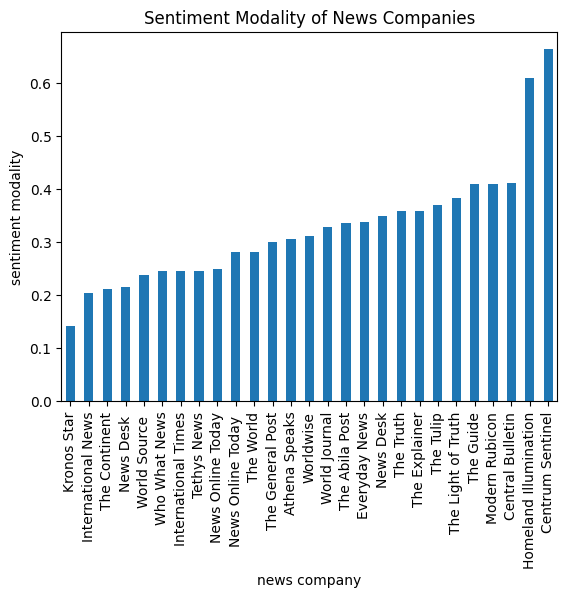

In [224]:
event_day.groupby(['news_company'])['sentiment_modality'].mean().sort_values().plot(kind='bar', xlabel='news company', ylabel='sentiment modality', title='Sentiment Modality of News Companies');

A Bar graph of news media coverage with the count being sentiment modality.
Kronos Star has the lowest value in terms of sentient modality. 

In [ ]:
# def search_arrested_articles(employee, arrest_df):
#     if arrest_df['description'].__contains__(employee): 
#         return employee, True

# arrest_df['GASTech Employee'], arrest_df['Arrested'] = zip(*employee_records_df['FullName'].apply(lambda e: search_arrested_articles(e, arrest_df)))

In [ ]:
# chord_df = pd.DataFrame(columns=['source', 'target', 'weight'])

# tmp_lst = []

# for employee_from in emails_sent.index:
#     for employee_to in emails_sent.columns:
#         # record = (employee_from, employee_to, emails_sent[employee_to][employee_from])
#         record = (employee_from, employee_to, emails_sent[employee_to][employee_from])
#         tmp_lst.append(record)

# tmp = pd.DataFrame(tmp_lst)
# tmp
# chord_df = emails_sent.reset_index().apply(lambda e: [(e[1], e[0], emails_sent[e])])

# chord_df= emails_sent.index.to_series().str.get(1).apply(lambda e: [(e[1], e[0], emails_sent[e])])

# df2 = pd.MultiIndex.from_tuples(tmp_lst)
# def split(x):
#     return x[0][0], x[0][1], str(x[0][2])

# df2 = pd.DataFrame()
# df2['source'], df2['target'], df2['weight'] = tmp.map()

# df2 = pd.DataFrame(emails_sent.unstack())
# df2


# chord_df['source'], chord_df['target'], chord_df['weight'] = zip(*emails_sent.index.apply(lambda e: [splitchord(e, employee_) for employee_ in emails_sent.columns], axis=1))
# chord_df.head()


In [ ]:
# define the model
# def define_model(vocab_size, max_length):
#     model = Sequential()
#     model.add(Embedding(vocab_size, 100, input_length=max_length))
#     model.add(Conv1D(32, 8, activation='relu'))
#     model.add(MaxPooling1D(2))
#     model.add(Flatten())
#     model.add(Dense(10, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     # compile network
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     # summarize defined model
#     model.summary()
#     plot_model(model, to_file='model.png', show_shapes=True)
#     return model

In [ ]:
# fit network
# model.fit(Xtrain, ytrain, epochs=10, verbose=2)

In [ ]:
# save the model
# model.save('model.h5')
# train_docs, ytrain = load_clean_dataset(vocab, True)
# # load the model
# model = load_model('model.h5')
# # evaluate model on training dataset
# _, acc = model.evaluate(Xtrain, ytrain, verbose=0)
# print('Train Accuracy: %f' % (acc*100))
# # evaluate model on test dataset
# _, acc = model.evaluate(Xtest, ytest, verbose=0)
# print('Test Accuracy: %f' % (acc*100))